<a href="https://colab.research.google.com/github/kmtsui/SummerProject2021/blob/master/TKI_OmniFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install latex
! sudo apt-get update
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 
! apt install cm-super
! pip install latex

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,326 kB]
Hit:12 http://ppa.launchpad.net/cra

In [2]:
# install uproot
! pip install uproot

     |████████████████████████████████| 290 kB 5.1 MB/s 


In [3]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
from matplotlib import pyplot as plt

import uproot

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Input
from keras.models import Model
from keras.callbacks import EarlyStopping

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.6.0


# OmniFold Example on TKI unfolding

## Setup the Datasets

In [6]:
# If you are using e.g. Google colab, clone the repo to access the data files
! git clone https://github.com/kmtsui/SummerProject2021

Cloning into 'SummerProject2021'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 29 (delta 8), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (29/29), done.


In [7]:
# for the time being just consider the dptt variable
def getSelectedEvents(filename):
    f = uproot.open(filename)
    t = f["selectedEvents"]
    array = np.transpose(np.asarray(t.arrays(["dptt_rec","pMomRec","dptt_truth","pMomTrue","weight", "topology", "cutBranch","D1Rec"], library="np", how=tuple)))
    return array

def getTrueEvents(filename):
    f = uproot.open(filename)
    t = f["trueEvents"]
    array = np.transpose(np.asarray(t.arrays(["dptt_truth","pMomTrue","weight", "topology"], library="np", how=tuple)))
    return array

def getRecoAndTrueEvents(filename):
# Reco events
  neut_reco_all = getSelectedEvents(filename)
  for i in range(len(neut_reco_all)):
    if neut_reco_all[i,0]<-700:       # limit the range
      neut_reco_all[i,0]=-700
    elif neut_reco_all[i,0]>700:
      neut_reco_all[i,0]=700
    if neut_reco_all[i,-2]==0:        # veto OOPS events
      if neut_reco_all[i,-1]>700:
        neut_reco_all[i,0]=750
        neut_reco_all[i,1]=1500
    else:
      #neut_reco_all[i,0]+=neut_reco_all[i,-2]*1500
      #neut_reco_all[i,1]+=neut_reco_all[i,-2]*1500
      #neut_reco_all[i,0]+=1500
      #neut_reco_all[i,1]+=1500
      neut_reco_all[i,0]=750+neut_reco_all[i,-2]*200   # some tricks to identify the events from signal and control samples
      neut_reco_all[i,1]=1500+neut_reco_all[i,-2]*200
    if neut_reco_all[i,-3]==2 or neut_reco_all[i,-3]==3:
      continue
    elif neut_reco_all[i,-3]>=5 and neut_reco_all[i,-3]<=8:    # some tricks to identify the different types of background events
      #neut_reco_all[i,2]=-950+(neut_reco_all[i,-3]-5)*50
      #neut_reco_all[i,3]=-950+(neut_reco_all[i,-3]-5)*50
      neut_reco_all[i,2]=750+(neut_reco_all[i,-3]-4)*200
      neut_reco_all[i,3]=1500+(neut_reco_all[i,-3]-4)*200
    elif neut_reco_all[i,-3]==11:
      #neut_reco_all[i,2]=-750
      #neut_reco_all[i,3]=-750
      neut_reco_all[i,2]=750
      neut_reco_all[i,3]=1500
    else:
      #neut_reco_all[i,2]=-999
      #neut_reco_all[i,3]=-999
      neut_reco_all[i,2]=1750
      neut_reco_all[i,3]=2500
  neut_true = getTrueEvents(filename)
  neut_true = np.delete(neut_true,neut_true[:,-1]==0,0) # remove CC0pi events for better unfolding
  for i in range(len(neut_true)):
    if neut_true[i,-1]==2 or neut_true[i,-1]==3:
      continue
    elif neut_true[i,-1]>=5 and neut_true[i,-1]<=8:
      neut_true[i,0]=750+(neut_true[i,-1]-4)*200    # some tricks to identify the different types of background events
      neut_true[i,1]=1500+(neut_true[i,-1]-4)*200
    elif neut_true[i,-1]==11:
      neut_true[i,0]=750
      neut_true[i,1]=1500
    else:
      neut_true[i,0]=1750
      neut_true[i,1]=2500
  #neut_true = neut_reco_all[:,2:6]
  return neut_reco_all,neut_true

# NEUT and GENIE dataset
neut_reco_all, neut_true = getRecoAndTrueEvents("SummerProject2021/neut_flattree.root")
genie_reco_all, genie_true = getRecoAndTrueEvents("SummerProject2021/genie_flattree.root")

No handles with labels found to put in legend.
No handles with labels found to put in legend.


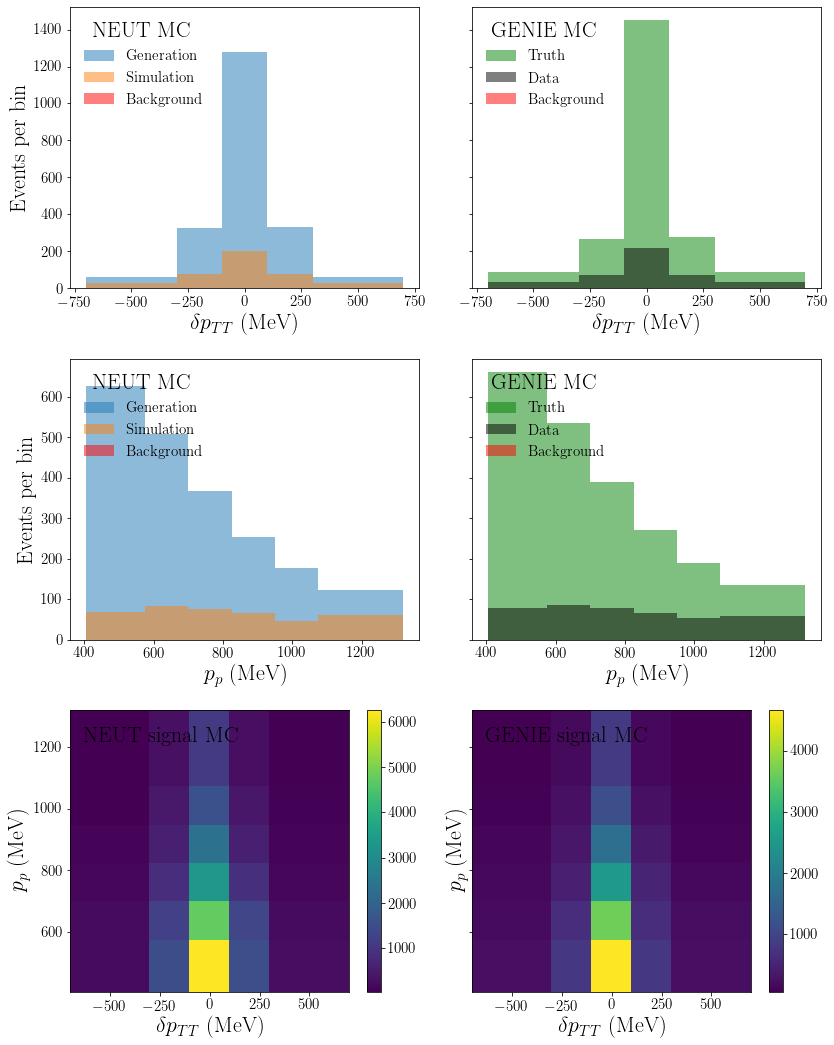

In [9]:
# define binnig for variables
bins_dptt = [-700,-300,-100,100,300,700]
bins_pp = [405,575,700,825,950,1075,1320]
bins = [bins_dptt,bins_pp]

x_labels = ['$\delta p_{TT}$ (MeV)','$p_p$ (MeV)']

fig, ax = plt.subplots(3,
                       2,
                       figsize=(12, 15),
                       #constrained_layout=True,
                       sharey='row'
                       )

# plot the x1 and x2 variables
for i in range(2):
        ax[i,0].set_xlabel(x_labels[i])
        ax[i,0].set_ylabel('Events per bin')
        ax[i,0].hist(neut_true[:,i], bins=bins[i], weights = neut_true[:,-2], **plot_style_2, label='Generation') # This is the MC truth distribution # scale down by 1/6 for get visualization
        ax[i,0].hist(neut_reco_all[:,i], bins=bins[i], weights = neut_reco_all[:,-4], **plot_style_2, label='Simulation') # MC reco distribution with background
        ax[i,0].hist(neut_reco_all[neut_reco_all[:,i+2]<-700][:,i], bins=bins[i], weights = neut_reco_all[neut_reco_all[:,i+2]<-700][:,-4], **plot_style_2, color="red", label='Background') # MC background prediction
        legend = ax[i,0].legend(
            title='NEUT MC',
            loc='upper left',
            frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

        ax[i,1].set_xlabel(x_labels[i])
        ax[i,1].hist(genie_true[:,i], bins=bins[i], weights = genie_true[:,-2], **plot_style_2, label='Truth',color="green") # Real data truth distribution # scale down by 1/6 for get visualization
        ax[i,1].hist(genie_reco_all[:,i], bins=bins[i], weights = genie_reco_all[:,-4], **plot_style_2, label='Data',color="black") # Real data reco distribution with background
        ax[i,1].hist(genie_reco_all[genie_reco_all[:,i+2]<-700][:,i], bins=bins[i], weights = genie_reco_all[genie_reco_all[:,i+2]<-700][:,-4], **plot_style_2, label='Background',color="red") # Real data background
        legend = ax[i,1].legend(
            title='GENIE MC',
            loc='upper left',
            frameon=False)
        plt.setp(legend.get_title(), multialignment='center')

# plot the 2d distribution
# you can clearly see the different correlation in the two datasets
ax[2,0].set_xlabel(x_labels[0])
ax[2,0].set_ylabel(x_labels[1])
h1 = ax[2,0].hist2d(neut_true[:,0], neut_true[:,1] , bins=(bins[0],bins[1]),label='NEUT signal MC')
fig.colorbar(h1[3],ax=ax[2,0])
legend = ax[2,0].legend(
    title='NEUT signal MC',
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[2,1].set_xlabel(x_labels[0])
ax[2,1].set_ylabel(x_labels[1])
h2 = ax[2,1].hist2d(genie_true[:,0], genie_true[:,1] , bins=(bins[0],bins[1]),label='GENIE signal MC')
fig.colorbar(h2[3],ax=ax[2,1])
legend = ax[2,1].legend(
    title='GENIE signal MC',
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.tight_layout()

fig.show()

## Unfold Data

In [10]:
# Number of unfolding iterations
iterations = 5

In [15]:
# Processed MC reco data for training
xvals_1 = np.concatenate((neut_reco_all, genie_reco_all))
# labelling as background and signal 
yvals_1 = np.concatenate((np.zeros(len(neut_reco_all)), np.ones(len(genie_reco_all))))

# Processed MC truth data data for training
xvals_2 = np.concatenate((neut_true, neut_true))
# background is the unweighted truth, signal is the weighted truth
yvals_2 = np.concatenate((np.zeros(len(neut_true)), np.ones(len(neut_true))))

# Push and pull weights in unfolding
weights = np.empty(shape=(iterations, 2, len(neut_reco_all)))
weights_true= np.empty(shape=(iterations, 2, len(neut_true)))
# shape = (#iteration, #step, #event)

# Set to 1 if only unfolding on dptt, 2 if both dptt and pp
nVars = 2

# Normalization layer for input variables
from tensorflow.keras.layers.experimental import preprocessing
normalizer = preprocessing.Normalization(axis=-1)
#input_data = np.concatenate((neut_reco_all[0:nVars],neut_reco_all[2:2+nVars]))
input_data = neut_reco_all
normalizer.adapt(input_data[:,0:nVars])

# tensorflow DNN model 
inputs = Input((nVars, )) # 2d vector as input
normalized_layer = normalizer(inputs)
# three hidden layers 
hidden_layer_1 = Dense(100, activation='relu')(normalized_layer)
hidden_layer_2 = Dense(100, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(100, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

# Early stopping criteria to avoid overtraining
earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [16]:
# from NN (DCTR)
def reweight(events):
    # f is the probability of the event is a real signal, 1-f is the probability of the event is a real background
    f = model.predict(events, batch_size=2000)
    # with such weight we can reweight a "background" distribution to a "signal" distribution
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

In [17]:
# Push and pull weights in unfolding
# initial iterative weights are the nominal weight
weights_pull = neut_reco_all[:,4]
weights_push = neut_reco_all[:,4]

w_data = genie_reco_all[:,4]

In [18]:
for i in range(iterations):
    print("\nITERATION: {}\n".format(i + 1))

    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("STEP 1\n")

    # weights_push = weights from previous interation
    # w_data is the "real" data
    weights_1 = np.concatenate((weights_push, w_data))

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1[:,0:nVars], yvals_1, weights_1)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    # Classification at reco level
    model.fit(X_train_1, 
              Y_train_1,
              sample_weight=w_train_1,
              epochs=200,
              batch_size=100,
              validation_data=(X_test_1, Y_test_1, w_test_1),
              callbacks=[earlystopping],
              verbose=1)

    # reco events weights after reco level reweight
    weights_pull = weights_push * reweight(neut_reco_all[:,0:nVars])
    
    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    # Training for events that don't pass reco
    # "Signal" is true MC events after reco level reweight, "background" is the un-weighted true MC events
    xvals_1b = np.concatenate((neut_reco_all[:,2:2+nVars],neut_reco_all[:,2:2+nVars]))
    yvals_1b = np.concatenate([np.ones(len(neut_reco_all)),np.zeros(len(neut_reco_all))])
    weights_1b = np.concatenate((weights_pull,neut_reco_all[:,4]))
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=200,
              batch_size=100,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    # truth events weights after reco level reweight
    average_vals = neut_true[:,2]*reweight(neut_true[:,0:nVars])

    ###
    
    weights[i, :1, :] = weights_pull
    weights_true[i,:1,:] = average_vals

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\nSTEP 2\n")

    # "Signal" is MC truth events after reco level reweight, "background" is the un-weighted true MC events
    weights_2 = np.concatenate((neut_true[:,2], average_vals))

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2[:,0:nVars], yvals_2, weights_2)

    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=200,
              batch_size=100,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    # weights after truth level reweight
    weights_true[i, 1:2, :] = reweight(neut_true[:,0:nVars])*neut_true[:,2]
    weights_push = reweight(neut_reco_all[:,2:2+nVars])*neut_reco_all[:,4]
    ### 
    
    weights[i, 1:2, :] = weights_push


ITERATION: 1

STEP 1

Epoch 1/200
272/272 [==============================] - 3s 9ms/step - loss: 0.0593 - accuracy: 0.4971 - val_loss: 0.0594 - val_accuracy: 0.4912
Epoch 2/200
272/272 [==============================] - 1s 4ms/step - loss: 0.0593 - accuracy: 0.5008 - val_loss: 0.0594 - val_accuracy: 0.4901
Epoch 3/200
272/272 [==============================] - 1s 3ms/step - loss: 0.0592 - accuracy: 0.5020 - val_loss: 0.0596 - val_accuracy: 0.5750
Epoch 4/200
272/272 [==============================] - 1s 3ms/step - loss: 0.0593 - accuracy: 0.5127 - val_loss: 0.0594 - val_accuracy: 0.5183
Epoch 5/200
272/272 [==============================] - 1s 3ms/step - loss: 0.0592 - accuracy: 0.5059 - val_loss: 0.0594 - val_accuracy: 0.5061
Epoch 6/200
272/272 [==============================] - 1s 3ms/step - loss: 0.0593 - accuracy: 0.5074 - val_loss: 0.0594 - val_accuracy: 0.5203
Epoch 7/200
272/272 [==============================] - 1s 4ms/step - loss: 0.0592 - accuracy: 0.5062 - val_loss: 0.0594

<Figure size 864x360 with 0 Axes>

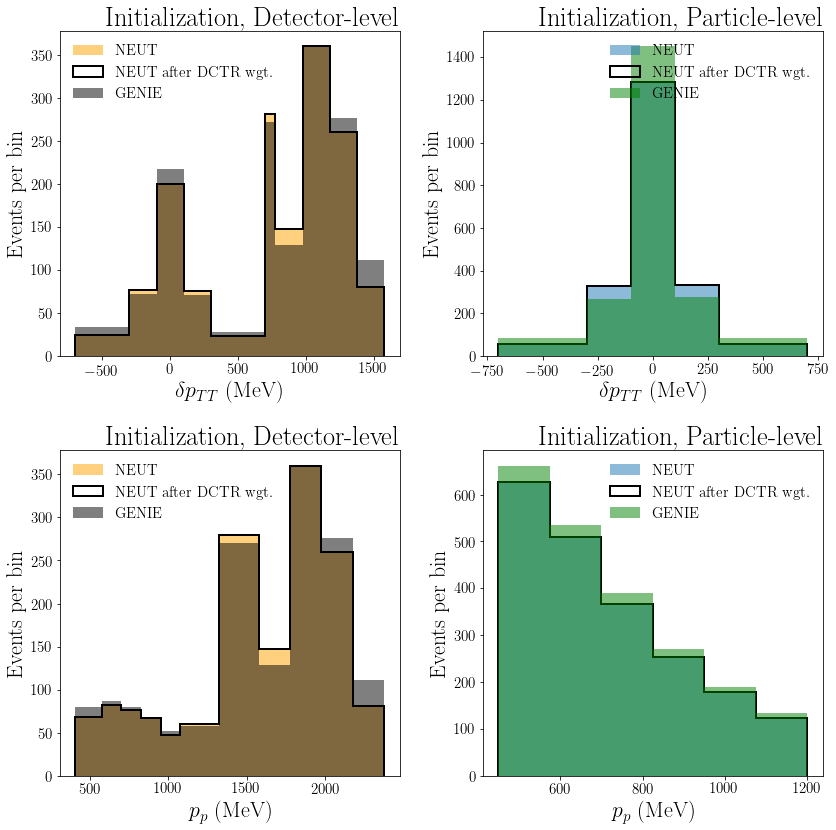

In [21]:
# Plot the initial distribution

bins_dptt_reco = [-700,-300,-100,100,300,700,775,975,1175,1375,1575]
bins_pp = [405,575,700,825,950,1075,1320,1575,1775,1975,2175,2375]

bins_reco = [bins_dptt_reco,bins_pp]

bins_dptt_truth = [-700,-300,-100,100,300,700]
bins_pp_truth = [450,575,700,825,950,1075,1200]

bins_truth = [bins_dptt_truth,bins_pp_truth]

x_labels = ['$\delta p_{TT}$ (MeV)','$p_p$ (MeV)']

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 12),
                       #constrained_layout=True,
                       #sharey='row'
                       )

for ix in range(2):
        #Detector-level
        ax[ix,0].set_title("Initialization, Detector-level",style='italic',loc='right')
        hist0 = ax[ix,0].hist(neut_reco_all[:,ix], # initial MC reco 
                        bins=bins_reco[ix],
                        color="orange",
                        label='NEUT',
                        weights=neut_reco_all[:,4],
                        **plot_style_2)

        _,_,_= ax[ix,0].hist(
            neut_reco_all[:,ix], # MC reco after reweight
            bins=bins_reco[ix],
            label='NEUT after DCTR wgt.',
            weights=neut_reco_all[:,4],
            **plot_style_1)
        _,_,_= ax[ix,0].hist(genie_reco_all[:,ix], # data reco
                        bins=bins_reco[ix],
                        label='GENIE',
                        weights=genie_reco_all[:,4],
                        **plot_style_2,
                        color="black")
        ax[ix,0].legend(frameon=False)
        ax[ix,0].set_xlabel(x_labels[ix])
        ax[ix,0].set_ylabel("Events per bin")

        #Particle-level
        ax[ix,1].set_title("Initialization, Particle-level",style='italic',loc='right')
        _,_,_=ax[ix,1].hist(neut_true[:,ix], # initial MC truth
                        bins=bins_truth[ix],
                        label='NEUT',
                        weights=neut_true[:,2],
                        **plot_style_2)

        _,_,_= ax[ix,1].hist(
            neut_true[:,ix],
            bins=bins_truth[ix],
            label='NEUT after DCTR wgt.', # MC truth after reweight
            weights=neut_true[:,2],
            **plot_style_1)
        _,_,_= ax[ix,1].hist(genie_true[:,ix], # real data truth
                        bins=bins_truth[ix],
                        label='GENIE',
                        **plot_style_2,
                        weights=genie_true[:,2],
                        color="green")
        ax[ix,1].legend(frameon=False)
        ax[ix,1].set_xlabel(x_labels[ix])
        ax[ix,1].set_ylabel("Events per bin")

fig.tight_layout()

plt.savefig("plot_0.pdf")



ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:
ITERATION 5:


<Figure size 864x360 with 0 Axes>

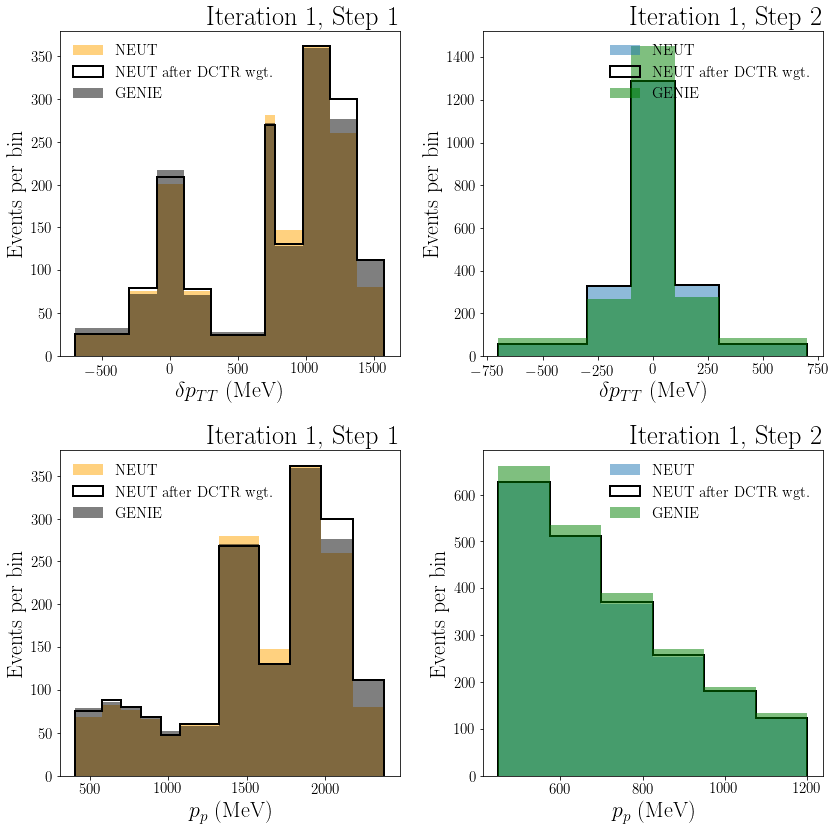

<Figure size 864x360 with 0 Axes>

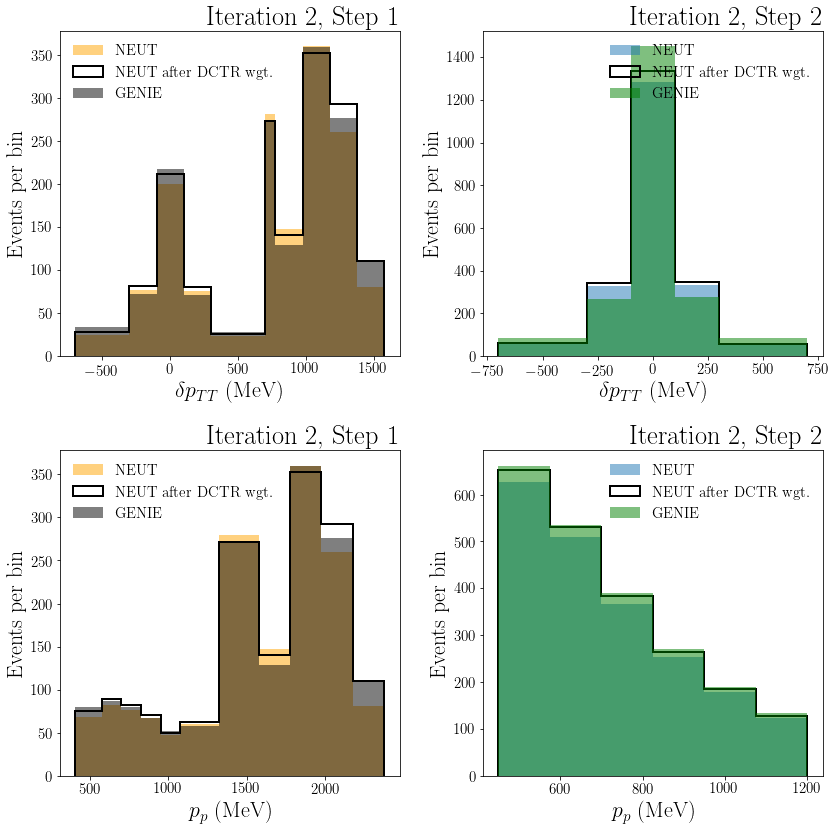

<Figure size 864x360 with 0 Axes>

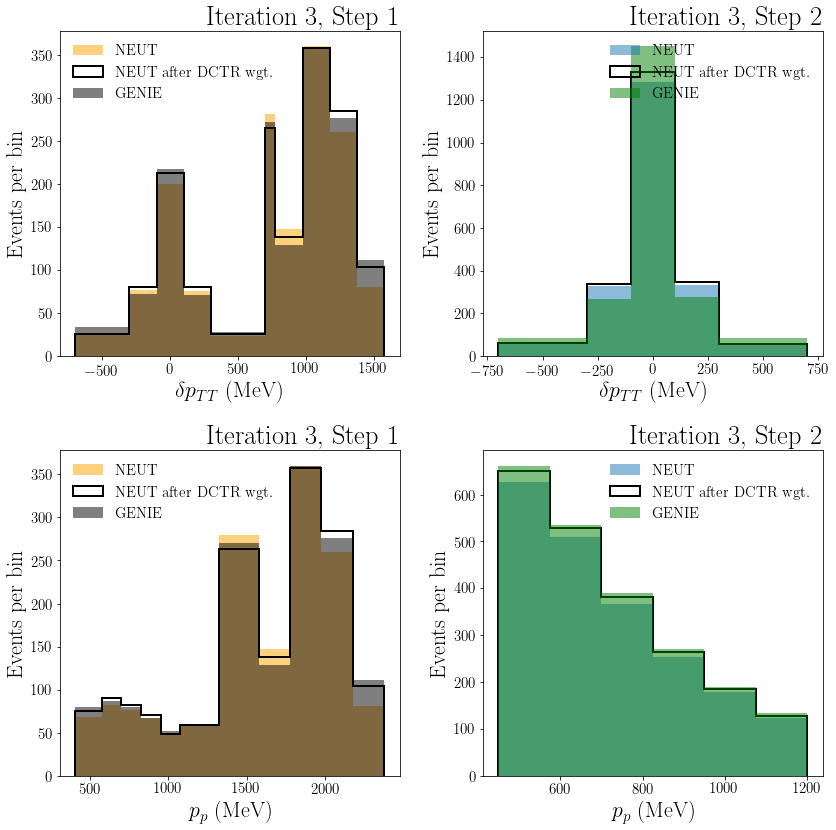

<Figure size 864x360 with 0 Axes>

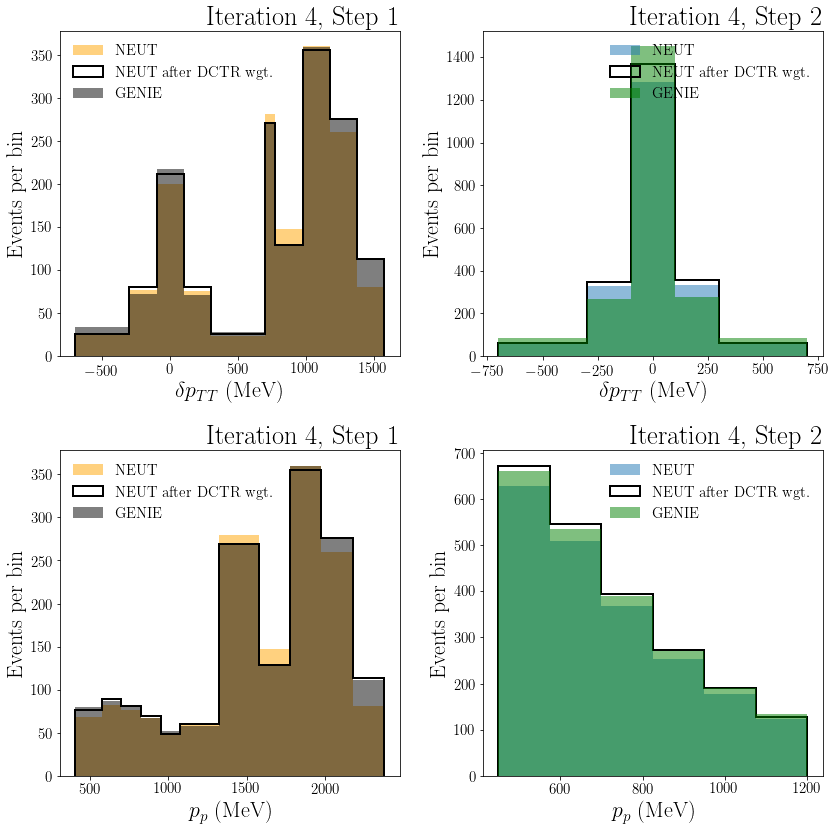

<Figure size 864x360 with 0 Axes>

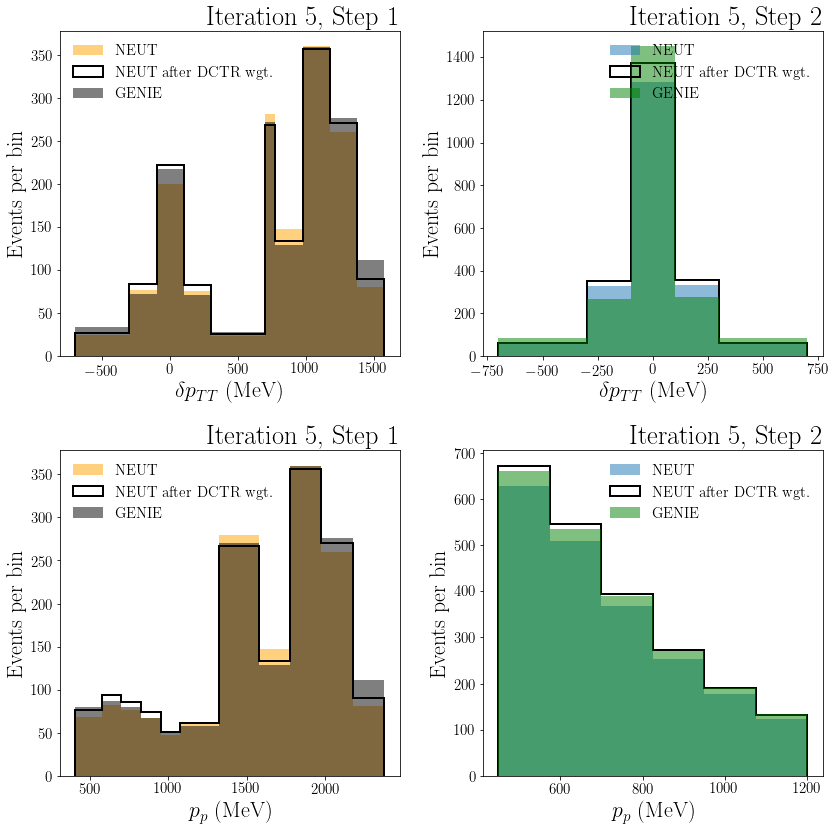

In [22]:
bins_dptt_reco = [-700,-300,-100,100,300,700,775,975,1175,1375,1575]
bins_pp = [405,575,700,825,950,1075,1320,1575,1775,1975,2175,2375]

bins_reco = [bins_dptt_reco,bins_pp]

# binning for plotting only the signal events
bins_dptt_truth = [-700,-300,-100,100,300,700]
# binning for plotting also the background events
#bins_dptt_truth = [-700,-300,-100,100,300,700,775,975,1175,1375,1575,1775]

bins_pp_truth = [450,575,700,825,950,1075,1200]

bins_truth = [bins_dptt_truth,bins_pp_truth]

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(2,2,
                       figsize=(12, 12),
                       #constrained_layout=True,
                       #sharey='row'
                       )
    
    for ix in range(2):
            #Detector-level
            ax[ix,0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
            hist0 = ax[ix,0].hist(neut_reco_all[:,ix], # initial MC reco 
                        bins=bins_reco[ix],
                        color="orange",
                        label='NEUT',
                        weights=neut_reco_all[:,4],
                            **plot_style_2)

            _,_,_= ax[ix,0].hist(
                neut_reco_all[:,ix], # MC reco after reweight
            bins=bins_reco[ix],
            label='NEUT after DCTR wgt.',
                weights=weights[i, 0, :],
                **plot_style_1)
            _,_,_= ax[ix,0].hist(genie_reco_all[:,ix], # data reco
                        bins=bins_reco[ix],
                        label='GENIE',
                        weights=genie_reco_all[:,4],
                            **plot_style_2,
                            color="black")
            ax[ix,0].legend(frameon=False)
            ax[ix,0].set_xlabel(x_labels[ix])
            ax[ix,0].set_ylabel("Events per bin")

            #Particle-level
            ax[ix,1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
            _,_,_=ax[ix,1].hist(neut_true[:,ix], # initial MC truth
                        bins=bins_truth[ix],
                        label='NEUT',
                        weights=neut_true[:,2],
                            **plot_style_2)

            _,_,_= ax[ix,1].hist(
                neut_true[:,ix],
            bins=bins_truth[ix],
            label='NEUT after DCTR wgt.', # MC truth after reweight
                weights=weights_true[i, 1, :],
                **plot_style_1)
            _,_,_= ax[ix,1].hist(genie_true[:,ix], # real data truth
                        bins=bins_truth[ix],
                        label='GENIE',
                        **plot_style_2,
                        weights=genie_true[:,2],
                            color="green")
            ax[ix,1].legend(frameon=False)
            ax[ix,1].set_xlabel(x_labels[ix])
            ax[ix,1].set_ylabel("Events per bin")

    fig.tight_layout()
    
    plt.savefig("plot_"+str(i+1)+".pdf")